In [1]:
%load_ext autoreload
%autoreload 2

import random

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

import cpn_model
import config
import michaels_load
import mRNN
import stim_model


OBSERVER_TYPE = "gaussian"
LESION_PCT = 1.0
STIMULATION_TYPE = "gaussianExp"
CPN_ACTIVATION_TYPE = "Tanh"
EN_ACTIVATION_TYPE = "Tanh"
LESION_MODULE_ID = "F5"
OBS_OUT_DIM = 20
NUM_STIM_CHANNELS = 35
BATCH_SIZE = 64

observer, stimulus, lesion_instance, en_activation, cpn_activation, recovery_mode, recovery_str, \
        run_type_str, _, drop_module_idx = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_pct=LESION_PCT,
                                              lesion_module_id=LESION_MODULE_ID,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=35,
                                              obs_out_dim=OBS_OUT_DIM)

CPN_DATA_DIR = "cpn"
EN_DATA_DIR = "en"
MRNN_DIR = "mrnn"

In [2]:
# Set up the Michaels mRNN

# Our stimulation model
stimulus.reset(batch_size=BATCH_SIZE)

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       stimulus=stimulus)



In [3]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path())

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_cpn = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True
)

loader_en = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True
)

# Loader produces lists of len 2:
#  (input of batch, output of batch); which is:
#  (shape(<=batch_size, time, 21), shape(<=batch_size, time, 50))

torch.Size([341, 21])
torch.Size([1, 341, 50])
torch.Size([1, 341, 50])


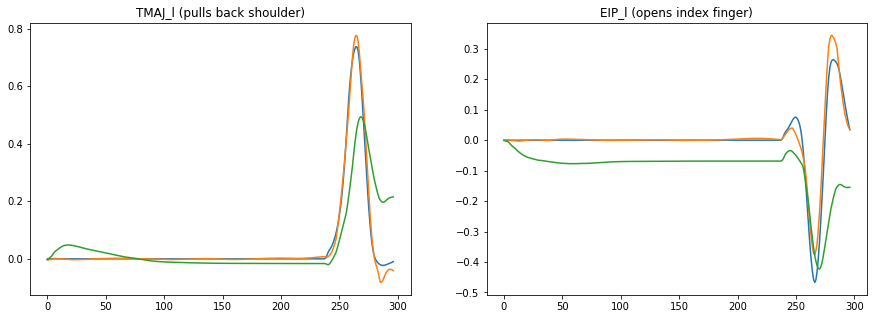

In [4]:
# Just some choice of examples, for graphical comparison
example_idx = random.randrange(len(dataset))
example_din, _, trial_len, example_dout = dataset[example_idx]

mike.set_lesion(None)
mike.reset()
reference_pred_healthy = mike.unroll(example_din.T)

# Lesion the network as we specified above
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()


print(example_din.shape)
print(reference_pred_healthy.shape)
print(reference_pred_lesioned.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(example_dout[:trial_len, 7].detach().numpy())
ax[0].plot(reference_pred_healthy[0, :trial_len, 7].detach().numpy())
ax[0].plot(reference_pred_lesioned[0, :trial_len, 7].detach().numpy())
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(example_dout[:trial_len, 45].detach().numpy())
ax[1].plot(reference_pred_healthy[0, :trial_len, 45].detach().numpy())
ax[1].plot(reference_pred_lesioned[0, :trial_len, 45].detach().numpy())

plt.show()

In [5]:
for b in loader_en:
    din, trial_end, trial_len, dout = b
    print(din.dtype, trial_end.dtype, trial_len.dtype, dout.dtype)

torch.float32 torch.float32 torch.int64 torch.float32
torch.float32 torch.float32 torch.int64 torch.float32
torch.float32 torch.float32 torch.int64 torch.float32
torch.float32 torch.float32 torch.int64 torch.float32
torch.float32 torch.float32 torch.int64 torch.float32
torch.float32 torch.float32 torch.int64 torch.float32
torch.float32 torch.float32 torch.int64 torch.float32
torch.float32 torch.float32 torch.int64 torch.float32


In [6]:
def unroll(cpn, mike, en, din, trial_end, observer,
           drop_module_idx=None, retain_stim_grads=False):
    batch_size = din.shape[0]
    steps = din.shape[1]
    
    stims = []
    preds = torch.zeros(batch_size, steps - 1, en.out_dim)
    actuals = torch.zeros(batch_size, steps - 1, en.out_dim)
    
    # This is the actual, which EN predicts
    mike_out = mike(din[:, 0, :].T)
    for tidx in range(steps - 1):
        obs = mike.observe(observer, drop_module_idx=drop_module_idx)
        assert len(obs) == 2
        new_obs = torch.cat((torch.tensor(obs[0]).float(), torch.tensor(obs[1]).float()),
                            axis=1)
        new_obs.requires_grad = False
        assert new_obs.shape == (batch_size, obs_dim)

        # cpn recieves (obs, trial_end)
        cpn_in = torch.cat((new_obs, trial_end[:, tidx, :]), axis=1)
        # output is (batch_size, num_stim_channels)
        new_stim = cpn(cpn_in)
        assert new_stim.shape == (batch_size, mike.stimulus.num_stim_channels)
        if retain_stim_grads:
            new_stim.retain_grad()
        stims.append(new_stim)
            
        # en receives (obs, stims, trial_end)
        en_in = torch.cat((new_obs, new_stim, trial_end[:, tidx, :]), axis=1)
        cur_pred = en(en_in)
        preds[:, tidx, :] = cur_pred[:, :]
            
        # new_stim will be cloned in here, to prevent accidentally backprop-ing
        # through the "brain", aka mike.
        mike.stimulate(new_stim)
                
        # Note that 'preds' lags 'actual' by a time step, hence
        # 'pred' is a prediction of the actual en activity
        mike_out = mike(din[:, tidx + 1, :].T)
        actuals[:, tidx, :] = mike_out[:, :]
        
    return actuals, preds, stims, 

In [21]:
def train_an_en(mike, observer, cpn, data_loader, en=None,
                last_loss=1, drop_module_idx=None):
    # the last EN we were working on training, for easy access
    global recent_en
    
    # Obs: observer.out_dim * 2
    obs_dim = observer.out_dim * 2
    # Stim: mike.stimulus.num_stim_channels
    # +1 for trial_end
    en_in_dim = obs_dim + mike.stimulus.num_stim_channels + 1
    if en is None or last_loss > 0.05:
        en = stim_model.StimModelLSTM(en_in_dim, mike.output_dim,
                num_neurons=en_in_dim, activation_func=torch.nn.Tanh)
        recent_en = en
    vl = torch.ones(1)
    opt_en = AdamW(en.parameters(), lr=9e-3, weight_decay=0.02)

    checkpoint_eidx = 0
    eidx = -1
    while True:
        for batch in data_loader:
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
            
            eidx += 1
            opt_en.zero_grad()
            mike.reset()
            en.reset()
            cpn.reset()
            loss = torch.nn.MSELoss()
            
            for p in opt_en.param_groups:
                if eidx < 3:
                    p['lr'] = 2e-2
                else:
                    if vl.item() < 0.005:
                        p['lr'] = 5e-3
                    else:
                        p['lr'] = 9e-3
                
    
            cpn_noise = cpn_model.CPNNoiseyLSTMCollection(cpn, noise_var=(0.1 * last_loss))
        
            # Just in case...
            for param in cpn_noise.parameters():
                param.requires_grad=False
            for param in mike.parameters():
                param.requires_grad=False

            actual, preds, _ = unroll(cpn_noise, mike, en, din, trial_end,
                                      observer, drop_module_idx=drop_module_idx)
        
            rl = loss(preds, actual)
            rl.backward()
            opt_en.step()
        
            # Verify against the actual CPN
            mike.reset()
            en.reset()
            cpn.reset()
            loss = torch.nn.MSELoss()
            actual_val, preds_val, _ = unroll(cpn, mike, en, din,
                                              trial_end, observer,
                                              drop_module_idx=drop_module_idx)
           
            vl = loss(preds_val, actual_val)
            print("en", eidx, rl.item(), "first 30:",
                  loss(preds[:30, :, :], actual[:30, :, :]).item(),
                  "val:", vl.item())
                    
            if torch.isnan(vl) or torch.isinf(vl) or vl.item() > 1.5 or (eidx - checkpoint_eidx) > 5000:
                # Emergency eject button
                en = stim_model.StimModelLSTM(en.in_dim, en.out_dim, num_neurons=en.num_neurons,
                                       activation_func=en.activation_func_t)
                recent_en = en
                opt_en = AdamW(en.parameters(), lr=1e-3, weight_decay=0.02)
                checkpoint_eidx = eidx
                
            if vl.item() < max(0.005 * last_loss, 0.00007) and eidx > 100:
                opt_en.zero_grad()
                done = True
                break
            else:
                done = False
                
        if done:
            break
    return en

In [ ]:
obs_dim = observer.out_dim * 2
# +1 for trial_end
cpn_in_dim = obs_dim + 1
#cpn = cpn_model.CPNModelLSTM(cpn_in_dim, mike.stimulus.num_stim_channels,
#                             num_neurons=cpn_in_dim, activation_func=torch.nn.Tanh)
#cpn.load_state_dict(torch.load('latest_cpn'))

# Up to 0.001:
#opt_cpn = AdamW(cpn.parameters(), lr=1e-4)

# 0.0008
#opt_cpn = AdamW(cpn.parameters(), lr=3e-5)

#opt_cpn = AdamW(cpn.parameters(), lr=1e-5)

loss = torch.nn.MSELoss()
rli = 0.03

cpn_losses = []
super_epoch_count = 0
en = None
while True:       
    super_epoch_count += 1
    
    for param in cpn.parameters():
        param.requires_grad=False
    
    #if super_epoch_count > 1:
    en = train_an_en(mike, observer, cpn, loader_en, last_loss=rli,
                     drop_module_idx=drop_module_idx)
    
    for param in cpn.parameters():
        param.requires_grad=True
    for param in en.parameters():
        param.requires_grad=False
    for param in mike.parameters():
        param.requires_grad=False
    
        
    recent_losses = []
    eidx = -1
    while eidx < 5000:
        for batch in loader_cpn:
            eidx += 1
            opt_cpn.zero_grad()
            cpn.reset()
            en.reset()
            mike.reset()
            
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
    
            actuals, preds, stims = unroll(cpn, mike, en, din, trial_end, observer,
                                           drop_module_idx=drop_module_idx,
                                           retain_stim_grads=True)
            
            rl = loss(preds, dout[:, 1:, :])
            rli = rl.item()
            rl.backward()  

            real_loss = loss(actuals, dout[:, 1:, :])
            pred_loss = loss(preds, actuals).item()
            print("cpn", eidx, rl.item(),
                  "en loss:", pred_loss,
                  "actual task loss:", real_loss.item())
            recent_losses.append(real_loss.item())
                                                          
            bail = False
            done = False
            # Emergency bailout; we diverged; start over :(
            if recent_losses[-1] > 2.0:
                cpn = cpn_model.CPNModelLSTM(target.shape[-1], cpn.out_dim,
                                   num_neurons=cpn.num_neurons,
                                   activation_func=cpn.activation_func_t)
                opt_cpn = AdamW(cpn.parameters(), lr=1e-4)
                bail = True
                break
    

            # Emergency bailout; time to retrain en
            if len(recent_losses) > 12 and (recent_losses[-1] > recent_losses[0] * 1.2):
                en = None
                bail = True
                break
            # Done
            elif rli < 1e-5:
                bail = True
                done = True
                break
            elif len(recent_losses) > 7:
                prev = None
                num_regressed = 0
                for l in recent_losses[-7:]:
                    if prev is not None and l > prev:
                        num_regressed += 1
                        
                prev = l
                if num_regressed > 3 or pred_loss > (rli/2) or pred_loss > 0.001:
                    if eidx < 20:
                        ben = None
                    bail = True
                    break
              
            torch.save(cpn.state_dict(), "latest_cpn")
            torch.save(en.state_dict(), "latest_en")
            cpn_losses.append(rli)
            opt_cpn.step()
                
        if bail:
            break
            
    if done:
        break



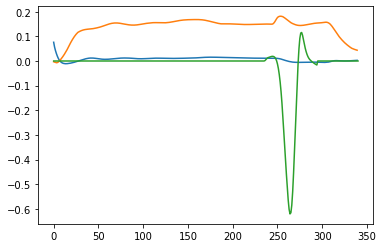

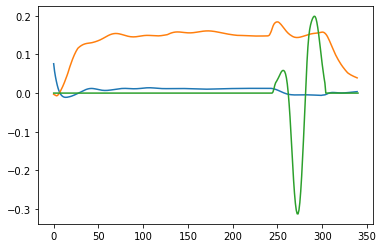

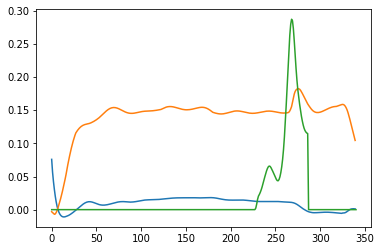

In [85]:
plt.plot(preds[0, :, 45].detach().numpy())
plt.plot(actuals[0, :, 45].detach().numpy())
plt.plot(dout[0, :, 45].detach().numpy())
plt.show()

plt.plot(preds[-1, :, 45].detach().numpy())
plt.plot(actuals[-1, :, 45].detach().numpy())
plt.plot(dout[-1, :, 45].detach().numpy())
plt.show()

plt.plot(preds[20, :, 45].detach().numpy())
plt.plot(actuals[20, :, 45].detach().numpy())
plt.plot(dout[20, :, 45].detach().numpy())
plt.show()